In [133]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [134]:
# Load files
l_stops_file = '/Users/em/Documents/Cleaned_Data/Crime_Analysis/CTA_-_System_Information_-_List_of__L__Stops_-_Map.csv'
l_station_entries_file = '/Users/em/Documents/Cleaned_Data/Crime_Analysis/CTA_-_Ridership_-__L__Station_Entries_-_Monthly_Day-Type_Averages___Totals_20231109.csv'

Notes on l_stop dataset: 
- Each row represents a different stop, identified by a STOP_ID 
- There can be multiple stops per station (i.e. one station that has a stop going in one direction, and another the other direction)
- Each station is identified by a STATION_NAME and a unique MAP_ID

In [135]:
# Read the CSV files into dataframes
l_stops_df = pd.read_csv(l_stops_file)
l_station_entries_df = pd.read_csv(l_station_entries_file)

# Display the first few rows of each dataset for initial examination
l_stops_df.head(), l_station_entries_df.head()

#l_stops_df.describe(),l_station_entries_df.describe()

(   STOP_ID                     STOP_NAME  STATION_NAME  MAP_ID    ADA    RED  \
 0    30082           Cicero (Loop-bound)        Cicero   40420   True  False   
 1    30151     Central Park (Loop-bound)  Central Park   40780   True  False   
 2    30184  Halsted/63rd (Ashland-bound)       Halsted   40940   True  False   
 3    30044     Cumberland (O'Hare-bound)    Cumberland   40230   True  False   
 4    30092         Racine (O'Hare-bound)        Racine   40470  False  False   
 
     BLUE      G    BRN      P   Pexp      Y    Pnk      O  \
 0  False  False  False  False  False  False   True  False   
 1  False  False  False  False  False  False   True  False   
 2  False   True  False  False  False  False  False  False   
 3   True  False  False  False  False  False  False  False   
 4   True  False  False  False  False  False  False  False   
 
                   Location  
 0   (41.85182, -87.745336)  
 1  (41.853839, -87.714842)  
 2  (41.778943, -87.644244)  
 3  (41.984246, -8

Data Cleaning Process

In [136]:
# 1.) Check initial shape of the dataframes and print results
initial_shapes = {"l_stops_df": l_stops_df.shape,
    "l_station_entries_df": l_station_entries_df.shape}
print("Initial Shapes:",initial_shapes)

# 2.) Check for missing values in each dataset and print results
missing_values = {
    "l_stops_df": l_stops_df.isnull().sum(),
    "l_station_entries_df": l_station_entries_df.isnull().sum()
}

# 3.) Convert date columns to datetime objects for consistency
l_station_entries_df['month_beginning'] = pd.to_datetime(l_station_entries_df['month_beginning'])
print("\nMissing Values:", missing_values)

Initial Shapes: {'l_stops_df': (300, 15), 'l_station_entries_df': (38481, 7)}

Missing Values: {'l_stops_df': STOP_ID         0
STOP_NAME       0
STATION_NAME    0
MAP_ID          0
ADA             0
RED             0
BLUE            0
G               0
BRN             0
P               0
Pexp            0
Y               0
Pnk             0
O               0
Location        0
dtype: int64, 'l_station_entries_df': station_id                  0
stationame                  0
month_beginning             0
avg_weekday_rides           0
avg_saturday_rides          0
avg_sunday-holiday_rides    0
monthtotal                  0
dtype: int64}


In [137]:
# 4. Format the columns of both dataframes
def format_column_names(df):
    # Replace spaces with underscores and capitalize the first letter of each word
    df.columns = df.columns.str.replace(' ', '_').str.title()
    return df

l_stops_df = format_column_names(l_stops_df)
l_station_entries_df = format_column_names(l_station_entries_df)

# 5. Rename columns in both dataframes
l_stops_df.rename(columns={'Stop_Id': 'Stop_ID', 'Map_Id': 'Station_ID', 'Ada': 'Accessible_Station', 'Y': 'Yellow', 'G':'Green', 'Brn': 'Brown', 'P': 'Purple', 'Pnk': 'Pink', 'Pexp': 'Purple_Express', 'O': 'Orange'}, inplace=True)
l_station_entries_df.rename(columns={'Station_Id': 'Station_ID', 'Stationame': 'Station_Name', 'Avg_Sunday-Holiday_Rides': 'Avg_Sunday/Holiday_Rides', 'Monthtotal': 'Monthly_Total'}, inplace=True)
l_stops_df.head(), l_station_entries_df.head()

# 6. Extract latitude and longitude from the 'Location' column
l_stops_df[['Latitude', 'Longitude']] = l_stops_df['Location'].str.strip('()').str.split(', ', expand=True).astype(float)

# 7. Define and apply the function to extract month and year from l_station_entries_df dataframe
def extract_month_year(df, date_column):
    # Make sure the date_column is a datetime dtype
    df[date_column] = pd.to_datetime(df[date_column])
    
    # Extract month and year into separate columns
    df['Month'] = df[date_column].dt.month
    df['Year'] = df[date_column].dt.year
    
    return df
l_station_entries_df = extract_month_year(l_station_entries_df, 'Month_Beginning')


In [138]:
#Validate station IDs in both datasets before merging data

# Convert the station_id columns to sets
set_station_ids_l_stops_df = set(l_stops_df['Station_ID'])
set_station_ids_l_station_entries_df = set(l_station_entries_df['Station_ID'])

# Find station IDs in l_stops_df that are not in l_station_entries_df
unique_to_l_stops_df = set_station_ids_l_stops_df - set_station_ids_l_station_entries_df

# Find station IDs in l_station_entries_df that are not in l_stops_df
unique_to_l_station_entries_df = set_station_ids_l_station_entries_df - set_station_ids_l_stops_df

print("Station IDs unique to l_stops_df:", unique_to_l_stops_df)
print("Station IDs unique to l_station_entries_df:", unique_to_l_station_entries_df)

unique_station_ids = [41580, 40200, 40500, 40640]

# Filter the DataFrame for the unique station IDs
unique_stations_details = l_station_entries_df[l_station_entries_df['Station_ID'].isin(unique_station_ids)]

# Display the filtered information
print(unique_stations_details)

#NOTE: Validated the three stations (Washington/State, Madison/Wabash, and Randolph/Wabash) were replaced by Washington/Wabash station
# and Homan station closed 

Station IDs unique to l_stops_df: set()
Station IDs unique to l_station_entries_df: {41580, 40200, 40500, 40640}
       Station_ID      Station_Name Month_Beginning  Avg_Weekday_Rides  \
20          40500  Washington/State      2001-01-01             6805.1   
138         40640    Madison/Wabash      2001-01-01             3693.4   
139         40200   Randolph/Wabash      2001-01-01             5544.6   
162         40500  Washington/State      2001-02-01             6979.9   
279         40640    Madison/Wabash      2001-02-01             3886.5   
...           ...               ...             ...                ...   
30321       40200   Randolph/Wabash      2018-09-01                0.0   
30465       40200   Randolph/Wabash      2018-10-01                0.0   
30609       40200   Randolph/Wabash      2018-11-01                0.0   
30753       40200   Randolph/Wabash      2018-12-01                0.0   
30897       40200   Randolph/Wabash      2019-01-01                0.0   

In [139]:
# 8. Drop duplicates (Since there are multiple stops per stations, (i.e. one station that has a stop going in one direction, and another the other direction)
l_stops_df.drop_duplicates(subset='Station_ID', keep="last", inplace=True)

# 9. Drop unnecessary columns 
l_stops_reduced_df = l_stops_df[['Station_ID','Station_Name', 'Longitude', 'Latitude']]
l_stops_reduced_df

,Station_ID,Station_Name,Longitude,Latitude
27,40450,95th/Dan Ryan,-87.624342,41.722377
31,41140,King Drive,-87.615546,41.780130
43,40670,Western,-87.687364,41.916157
44,41380,Bryn Mawr,-87.658840,41.983504
48,41500,Montrose,-87.675047,41.961756
...,...,...,...,...
295,40480,Cicero,-87.744698,41.886519
296,41330,Montrose,-87.743574,41.961539
297,40650,North/Clybourn,-87.649177,41.910655
298,40890,O'Hare,-87.904223,41.977665


Merge the two dataframes into one dataframe

In [140]:
# Merge the two dataframes on 'Station_ID' with suffixes to handle duplicate column names
merged_df = pd.merge(l_stops_reduced_df, l_station_entries_df, on='Station_ID', how='left')

# Drop one of the duplicate columns if they contain the same information
merged_df.drop('Station_Name_x', axis=1, inplace=True)

# Rename 'Station_Name_l_stops' to 'Station_Name'
merged_df.rename(columns={'Station_Name_y': 'Station_Name'}, inplace=True)

#Define new order of df
new_column_order = ['Year', 'Month', 'Month_Beginning','Station_ID', 'Station_Name', 'Longitude', 'Latitude', 'Avg_Weekday_Rides', 'Avg_Saturday_Rides','Avg_Sunday/Holiday_Rides', 'Monthly_Total' ]

# Reorder the DataFrame columns
merged_df = merged_df[new_column_order]
merged_df

,Year,Month,Month_Beginning,Station_ID,Station_Name,Longitude,Latitude,Avg_Weekday_Rides,Avg_Saturday_Rides,Avg_Sunday/Holiday_Rides,Monthly_Total
0,2001,1,2001-01-01,40450,95th/Dan Ryan,-87.624342,41.722377,14162.6,7472.8,4914.4,366040
1,2001,2,2001-02-01,40450,95th/Dan Ryan,-87.624342,41.722377,14445.6,7166.5,5282.8,338708
2,2001,3,2001-03-01,40450,95th/Dan Ryan,-87.624342,41.722377,14521.9,7686.8,5239.8,378875
3,2001,4,2001-04-01,40450,95th/Dan Ryan,-87.624342,41.722377,14106.8,7716.5,5349.4,353856
4,2001,5,2001-05-01,40450,95th/Dan Ryan,-87.624342,41.722377,14591.5,7482.8,5357.8,377733
...,...,...,...,...,...,...,...,...,...,...,...
37956,2023,2,2023-02-01,40230,Cumberland,-87.838028,41.984246,1518.3,702.0,573.0,35466
37957,2023,3,2023-03-01,40230,Cumberland,-87.838028,41.984246,1610.3,990.0,617.8,43469
37958,2023,4,2023-04-01,40230,Cumberland,-87.838028,41.984246,1767.9,925.0,649.8,43231
37959,2023,5,2023-05-01,40230,Cumberland,-87.838028,41.984246,1861.1,1172.3,879.0,50029


Exploratory Analysis

In [141]:
# Create a summary metric - average monthly ridership for each stop
l_summary = merged_df.groupby(['Station_ID', 'Station_Name']).agg(
    avg_monthly_ridership=pd.NamedAgg(column='Monthly_Total', aggfunc='mean')
).reset_index()

l_summary

,Station_ID,Station_Name,avg_monthly_ridership
0,40010,Austin-Forest Park,41995.103704
1,40020,Harlem-Lake,85896.381481
2,40030,Pulaski-Lake,39217.525926
3,40040,Quincy/Wells,154963.481481
4,40050,Davis,90185.651852
...,...,...,...
139,41660,Lake/State,391408.496296
140,41670,Conservatory,20703.830189
141,41680,Oakton-Skokie,18067.318519
142,41690,Cermak-McCormick Place,32876.754902


/Users/em/anaconda3/envs/crime_data/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/em/anaconda3/envs/crime_data/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/em/anaconda3/envs/crime_data/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/em/anaconda3/envs/crime_data/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

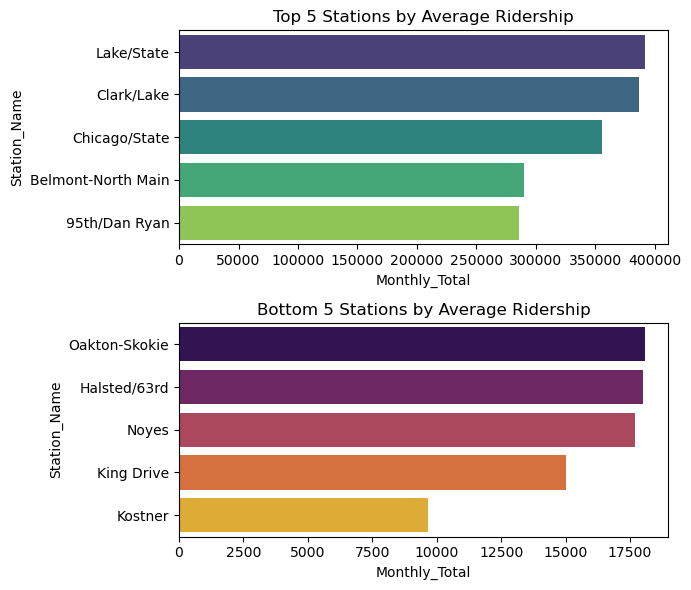

In [142]:
# Overall Popularity Analysis
station_popularity = merged_df.groupby('Station_Name').agg({'Monthly_Total': 'mean'}).sort_values(by='Monthly_Total', ascending=False)

# Top and bottom 5 stations
top_stations = station_popularity.head(5)
bottom_stations = station_popularity.tail(5)

# Plotting
plt.figure(figsize=(7,6))
plt.subplot(2, 1, 1)
sns.barplot(x=top_stations['Monthly_Total'], y=top_stations.index, palette='viridis')
plt.title('Top 5 Stations by Average Ridership')
plt.subplot(2, 1, 2)
sns.barplot(x=bottom_stations['Monthly_Total'], y=bottom_stations.index, palette='inferno')
plt.title('Bottom 5 Stations by Average Ridership')
plt.tight_layout()
plt.show()

/Users/em/anaconda3/envs/crime_data/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/em/anaconda3/envs/crime_data/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/em/anaconda3/envs/crime_data/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/em/anaconda3/envs/crime_data/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be rem

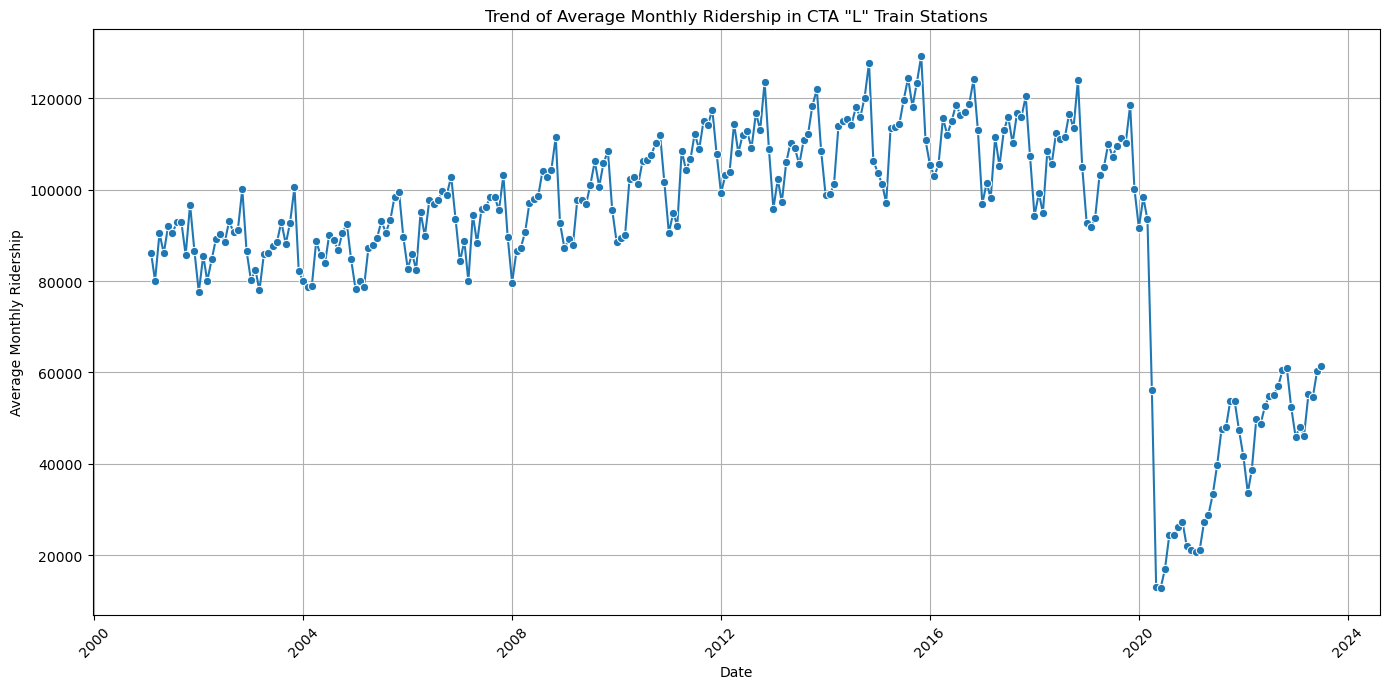

In [143]:
# Group by month and year to see trend over time
l_trend = merged_df.groupby(pd.Grouper(key='Month_Beginning', freq='M')).agg(
    avg_monthly_ridership=pd.NamedAgg(column='Monthly_Total', aggfunc='mean')
).reset_index()

# Plot the trend
plt.figure(figsize=(14, 7))  # Adjust the size to fit the trend line properly
sns.lineplot(data=l_trend, x='Month_Beginning', y='avg_monthly_ridership', marker='o')
plt.title('Trend of Average Monthly Ridership in CTA "L" Train Stations')
plt.xlabel('Date')
plt.ylabel('Average Monthly Ridership')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust layout to fit the plot and annotations nicely
plt.show()


/Users/em/anaconda3/envs/crime_data/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


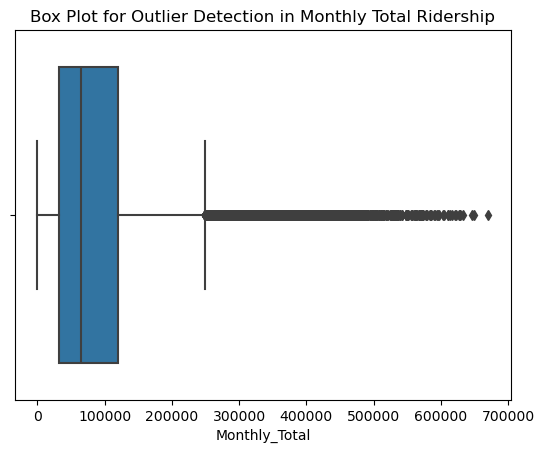

In [144]:
# Detecting outliers in 'Monthly_Total'
sns.boxplot(x=merged_df['Monthly_Total'])
plt.title('Box Plot for Outlier Detection in Monthly Total Ridership')
plt.show()

#Outlier Notes: Outliers may indicate unusual fluctuations in ridership, such as very high ridership due to a special event or very low ridership due to a station closure or other factors such as COVID.

In [146]:
#Run this code when done cleaning. Will create new CSV from cleaned dataframe and save to filepath
merged_df.to_csv('/Users/em/Documents/Cleaned_Data/L_Station_Cleaned.csv', index=False)